# **Rayan International AI Contest**

<font color='white' style='font-family: "Times New Roman", Times, serif; font-size: 24px;'><strong>Machine Learning & Deep Learning Course</strong></font>

<font color='white' style='font-family: "Times New Roman", Times, serif; font-size: 20px;'><em>**Title**: Pytorch workshop || **Part**: 2</em></font>
<br><br>
<font color='white' size=1>Copyright 2019. Created by Jose Marcial Portilla.</font>

# Loading Real Image Data
Let's learn the real deal, and work from a varied collection of .jpg files.

For this section we'll be working with a version of the Cats vs. Dogs dataset inspired by a classic <a href='https://www.kaggle.com/c/dogs-vs-cats'>Kaggle competition</a>.<br>
A quick note - do <strong>not</strong> download the dataset from Kaggle! Ours is a cleaned version of the data without any 0by0 files, etc.<br>The images are similar to ones available from the <a href='http://www.image-net.org/'>ImageNet</a> database.

We have organized the files into train and test folders, and further divided the images into CAT and DOG subfolders. In this way the file path contains the label.

### Image files directory tree
<pre>.
└── Data
    └── CATS_DOGS
        ├── test
        │   ├── CAT
        │   │   ├── 9374.jpg
        │   │   ├── 9375.jpg
        │   │   └── ... (3,126 files)
        │   └── DOG
        │       ├── 9374.jpg
        │       ├── 9375.jpg
        │       └── ... (3,125 files)       
        │           
        └── train
            ├── CAT
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (9,371 files)
            └── DOG
                ├── 0.jpg
                ├── 1.jpg
                └── ... (9,372 files)</pre>

## Perform standard imports

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import gzip
from torchvision.utils import make_grid

import pickle
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Examine the data
We'll us Python's built-in <a href='https://docs.python.org/3/library/os.html'>os module</a> to walk the directories collecting file names. We'll then use <a href='https://python-pillow.org/'>Pillow</a>, an extension to the Python Imaging Library (PIL), to open image files and extract image sizes. A pandas DataFrame will provide summary statistics on our data like max/min width & height from which we can choose our model parameters.

In [2]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
!gdown 10U7XfgoKsSs3kby1n6xAXWEUjnVrQr7B

Downloading...
From (original): https://drive.google.com/uc?id=10U7XfgoKsSs3kby1n6xAXWEUjnVrQr7B
From (redirected): https://drive.google.com/uc?id=10U7XfgoKsSs3kby1n6xAXWEUjnVrQr7B&confirm=t&uuid=2cb308b5-9159-46ab-aca5-f0a59c4d2871
To: /content/FashionMNIST.zip
100% 56.1M/56.1M [00:01<00:00, 31.9MB/s]


In [4]:
!unzip -q FashionMNIST.zip

In [6]:
# TEST YOUR VERSION OF PILLOW
with Image.open('FashionMNIST/train/Bag/100.jpg') as im:
    display(im)

### Create a list of image filenames

In [7]:
path = 'FashionMNIST'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

print('Images: ',len(img_names))

Images:  70000


### Create a DataFrame of image sizes (width x height)
It's worth noting that <tt>Image.open()</tt> doesn't read the entire image into memory, so it's a reasonable way to get image sizes.<br>
Still, this can take awhile.

## Image Preprocessing
Any network we define requires consistent input data. That is, the incoming image files need to have the same number of channels (3 for red/green/blue), the same depth per channel (0-255), and the same height and width. This last requirement can be tricky. How do we transform an 800x450 pixel image into one that is 224x224?
* <a href='https://en.wikipedia.org/wiki/Aspect_ratio_(image)'><strong>aspect ratio</strong></a>: the ratio of width to height (16:9, 1:1, etc.) An 800x450 pixel image has an aspect ration of 16:9. We can change the aspect ratio of an image by cropping it, by stretching/squeezing it, or by some combination of the two. In both cases we lose some information contained in the original. Let's say we crop 175 pixels from the left and right sides of our 800x450 image, resulting in one that's 450x450.
* <strong>scale</strong>: Once we've attained the proper aspect ratio we may need to scale an image up or down to fit our input parameters. There are several libraries we can use to scale a 450x450 image down to 224x224 with minimal loss.
* <a href=''><strong>normalization</strong></a>: when images are converted to tensors, the [0,255] rgb channels are loaded into range [0,1]. We can then normalize them using the generally accepted values of mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. For the curious, these values were obtained by the PyTorch team using a random 10,000 sample of <a href='http://www.image-net.org/'>ImageNet</a> images. There's a good discussion of this <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>here</a>, and the original source code can be found <a href='https://github.com/soumith/imagenet-multiGPU.torch/blob/master/donkey.lua#L154'>here</a>.

## Transformations
Before defining our Convolutional Network, let's look at a sample image and perform various transformations on it to see their effect.

In [10]:
bag = Image.open('FashionMNIST/train/Bag/100.jpg')
print(bag.size)
display(bag)

(28, 28)


This is how jupyter displays the original .jpg image. Note that size is given as (width, height).<br>
Let's look at a single pixel:

In [12]:
grey_val= bag.getpixel((0, 0))
print(grey_val)

6


The pixel at position [0,0] (upper left) of the source image has an rgb value of (90,95,98). This corresponds to <font style="background-color:rgb(90,95,98)">this color </font><br>
Great! Now let's look at some specific transformations.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor'><tt>transforms.ToTensor()</tt></a>
Converts a PIL Image or numpy.ndarray (HxWxC) in the range [0, 255] to a <tt>torch.FloatTensor</tt> of shape (CxHxW) in the range [0.0, 1.0]

torch.Size([1, 28, 28])


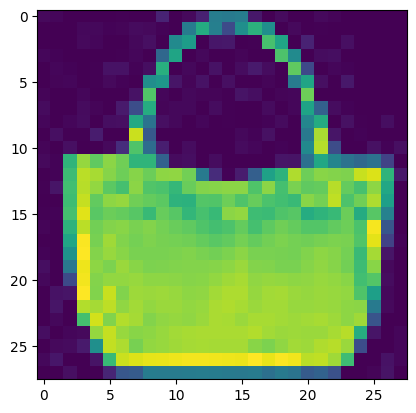

In [14]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(bag)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

This is the same image converted to a tensor and displayed using matplotlib. Note that the torch dimensions follow [channel, height, width]<br><br>
PyTorch automatically loads the [0,255] pixel channels to [0,1]:<br><br>
$\frac{90}{255}=0.3529\quad\frac{95}{255}=0.3725\quad\frac{98}{255}=0.3843$

In [15]:
im[0,0,0]

tensor(0.0235)

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>
If size is a sequence like (h, w), the output size will be matched to this. If size is an integer, the smaller edge of the image will be matched to this number.<br>i.e, if height > width, then the image will be rescaled to (size * height / width, size)

This resized the shortest side, and scaled the other. Let's try this on a small image.

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.CenterCrop'><tt>transforms.CenterCrop(<em>size</em>)</tt></a>
If size is an integer instead of sequence like (h, w), a square crop of (size, size) is made.

It may be better to resize the image first, then crop:

## Other affine transformations
An <a href='https://en.wikipedia.org/wiki/Affine_transformation'><em>affine</em></a> transformation is one that preserves points and straight lines. Examples include rotation, reflection, and scaling. For instance, we can double the effective size of our training set simply by flipping the images.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip'><tt>transforms.RandomHorizontalFlip(<em>p=0.5</em>)</tt></a>
Horizontally flip the given PIL image randomly with a given probability.

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation'><tt>transforms.RandomRotation(<em>degrees</em>)</tt></a>
If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).<br>
Run the cell below several times to see a sample of rotations.

### Scaling is done using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>

## Let's put it all together

___
## Normalization
Once the image has been loaded into a tensor, we can perform normalization on it. This serves to make convergence happen quicker during training. The values are somewhat arbitrary - you can use a mean of 0.5 and a standard deviation of 0.5 to convert a range of [0,1] to [-1,1], for example.<br>However, <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>research has shown</a> that mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] work well in practice.

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt>transforms.Normalize(<em>mean, std</em>)</tt></a>
Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input tensor
### $\quad\textrm {input[channel]} = \frac{\textrm{input[channel] - mean[channel]}}{\textrm {std[channel]}}$

Recall that before normalization, the upper-leftmost tensor had pixel values of <tt>[0.3529, 0.3725, 0.3843]</tt>.<br>
With normalization we subtract the channel mean from the input channel, then divide by the channel std.<br><br>
$\frac{(0.3529-0.485)}{0.229}=-0.5767\quad\frac{(0.3725-0.456)}{0.224}=-0.3725\quad\frac{(0.3843-0.406)}{0.225}=-0.0964$<br>

When displayed, matplotlib clipped this particular pixel up to [0,0,0] so it appears black on the screen. However, the appearance isn't important; the goal of normalization is improved mathematical performance.

### Optional: De-normalize the images
To see the image back in its true colors, we can apply an inverse-transform to the tensor being displayed.

Note that the original tensor was not modified:

Custom transform
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [17]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample
        img=sample.resize((self.output_size,self.output_size))


        return img


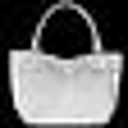

In [18]:
rescale_transform=Rescale(128)
im_new=rescale_transform(bag)
im_new

## Perform standard imports

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define transforms
In the previous section we looked at a variety of transforms available for data augmentation (rotate, flip, etc.) and normalization.<br>
Here we'll combine the ones we want, including the <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [19]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        #transforms.Resize(224),             # resize shortest side to 224 pixels
        #transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ])

test_transform = transforms.Compose([
        #transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.229])
    ])

## Prepare train and test sets, loaders
We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [61]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        # Initializing Captcha Dataset class
        super(CustomDataset, self).__init__()
        self.root=root
        # Listing all files in the provided root directory
        self.classes=sorted(os.listdir(root))
        # Initializing lists to store images and their respective labels
        self.images = []
        self.labels = []
        self.transform=transform
        self.target_transform=target_transform
        for class_name in self.classes:
          for img in os.listdir(os.path.join(root,class_name)):
            self.images.append(os.path.join(root,class_name,img))
            self.labels.append(self.classes.index(class_name))
        # Iterating through each file in the root directory

    def __len__(self):
        # Returning the total number of images
        return len(self.labels)

    def __getitem__(self, idx:int):
        # Retrieving image and target label based on index
        img, target = self.images[idx], self.labels[idx]

        # Checking if the index is a slice (multiple items requested)
        if isinstance(idx, slice):
            tmp = []
            # Iterating through each image in the slice
            for item in img:
                # Applying transformations if specified
                if self.transform is not None:
                    tmp.append(self.transform(self.read_image(item)))
                else:
                    tmp.append(self.read_image(item))
            img = tmp
        else:
            # Applying transformations if specified
            if self.transform is not None:
                img = self.transform(self.read_image(img))
            else:
                img = self.read_image(img)

        # Applying target transformations if specified

        # Returning image and target label
        return img, target

    # Method to read image from file path
    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img

    # Method to check if a file is an image file
    def is_image_file(self, filename):
        # Checking if filename ends with any of the specified image extensions
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

In [62]:
train_data=CustomDataset('FashionMNIST/train',transform=train_transform)
test_data=CustomDataset('FashionMNIST/test',transform=test_transform)

train_data[0][0].shape

torch.Size([1, 28, 28])

In [33]:
root = 'FashionMNIST'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [63]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names=train_data.classes
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

Training images available: 60000
Testing images available:  10000


In [64]:
b=next(iter(train_loader))

DATALOADER:https://pytorch.org/docs/stable/data.html

## Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

Label: [6 8 6 9 7 3 7 4 1 5]
Class: Shirt T-shirt Shirt Trouser Sneaker Dress Sneaker Pullover Bag Sandal


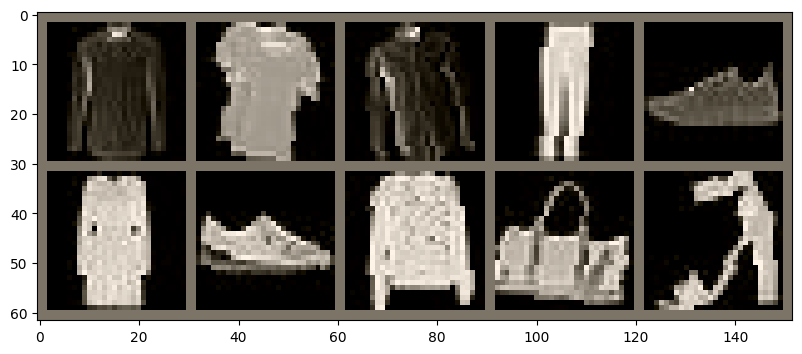

In [65]:
# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Define the model
Here we have a binary classification (2 output channels). So let's define the model.

In [66]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, X):
        out=X.view(-1,28*28)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [67]:
model=SimpleNet()
sample=torch.randn(10,28,28)
res=model(sample)
res.sum().backward()

<div class="alert alert-info"><strong>Why <tt>(54x54x16)</tt>?</strong><br>
With 224 pixels per side, the kernels and pooling layers result in $\;(((224-2)/2)-2)/2 = 54.5\;$ which rounds down to 54 pixels per side.</div>

### Instantiate the model, define loss and optimization functions
We're going to call our model "CNNmodel" to differentiate it from an "AlexNetmodel" we'll use later.

In [68]:
torch.manual_seed(101)
model = SimpleNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

SimpleNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Looking at the trainable parameters

In [69]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [54]:
count_parameters(model)

  100352
     128
    8192
      64
     640
      10
________
  109386


## Train the model
In the interests of time, we'll limit the number of training batches to 800, and the number of testing batches to 300. We'll train the model on 8000 of 18743 available images, and test it on 3000 out of 6251 images.

In [76]:
def accuracy(out, y_batch):
    return (torch.argmax(out, dim=1)==y_batch).float().mean()

In [79]:
import time
start_time = time.time()
from tqdm import tqdm
epochs = 3
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    # Run the training batches
    running_loss=0.
    for b, (X_train, y_train) in enumerate(tqdm(train_loader)):
        X_train=X_train.to(DEVICE)
        y_train=y_train.to(DEVICE)
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        # Print interim results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}')

    train_losses.append(running_loss/len(train_loader))

    # Run the testing batches
    with torch.no_grad():
        val_acc=0.
        val_running_loss=0.0
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            X_test=X_test.to(DEVICE)
            y_test=y_test.to(DEVICE)
            y_val = model(X_test)
            btch_acc=accuracy(y_val, y_test)
            val_acc+=btch_acc
            loss = criterion(y_val, y_test)
            val_running_loss+=loss.item()
    test_losses.append(val_running_loss/len(test_loader))
    test_correct.append(val_acc/len(test_loader))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

  0%|          | 7/1875 [00:00<01:00, 30.94it/s]

epoch:  0  batch:    0 [     0/8000]  loss: 0.71346003


  6%|▌         | 108/1875 [00:02<00:44, 39.40it/s]

epoch:  0  batch:  100 [  1000/8000]  loss: 0.61510497


 11%|█         | 207/1875 [00:06<00:52, 32.05it/s]

epoch:  0  batch:  200 [  2000/8000]  loss: 0.56570637


 16%|█▋        | 307/1875 [00:08<00:40, 38.99it/s]

epoch:  0  batch:  300 [  3000/8000]  loss: 0.41619080


 22%|██▏       | 408/1875 [00:11<00:37, 39.20it/s]

epoch:  0  batch:  400 [  4000/8000]  loss: 0.58840108


 27%|██▋       | 506/1875 [00:14<00:35, 38.37it/s]

epoch:  0  batch:  500 [  5000/8000]  loss: 0.67171949


 32%|███▏      | 605/1875 [00:16<00:41, 30.83it/s]

epoch:  0  batch:  600 [  6000/8000]  loss: 0.79006511


 38%|███▊      | 705/1875 [00:19<00:29, 39.87it/s]

epoch:  0  batch:  700 [  7000/8000]  loss: 0.46288645


 43%|████▎     | 806/1875 [00:22<00:28, 37.98it/s]

epoch:  0  batch:  800 [  8000/8000]  loss: 0.28190279


 48%|████▊     | 906/1875 [00:25<00:26, 36.00it/s]

epoch:  0  batch:  900 [  9000/8000]  loss: 0.41354248


 54%|█████▎    | 1006/1875 [00:27<00:22, 39.46it/s]

epoch:  0  batch: 1000 [ 10000/8000]  loss: 0.53165829


 59%|█████▉    | 1106/1875 [00:31<00:26, 29.29it/s]

epoch:  0  batch: 1100 [ 11000/8000]  loss: 0.72455370


 64%|██████▍   | 1207/1875 [00:33<00:16, 39.39it/s]

epoch:  0  batch: 1200 [ 12000/8000]  loss: 0.48777756


 70%|██████▉   | 1306/1875 [00:36<00:15, 37.42it/s]

epoch:  0  batch: 1300 [ 13000/8000]  loss: 0.44271868


 75%|███████▍  | 1406/1875 [00:38<00:12, 38.25it/s]

epoch:  0  batch: 1400 [ 14000/8000]  loss: 0.27971739


 80%|████████  | 1506/1875 [00:41<00:10, 36.72it/s]

epoch:  0  batch: 1500 [ 15000/8000]  loss: 0.42468223


 86%|████████▌ | 1607/1875 [00:44<00:07, 36.76it/s]

epoch:  0  batch: 1600 [ 16000/8000]  loss: 0.40505821


 91%|█████████ | 1708/1875 [00:47<00:04, 38.79it/s]

epoch:  0  batch: 1700 [ 17000/8000]  loss: 0.48193297


 96%|█████████▋| 1805/1875 [00:49<00:01, 39.67it/s]

epoch:  0  batch: 1800 [ 18000/8000]  loss: 0.53094512


  0%|          | 6/1875 [00:00<01:04, 28.96it/s]

epoch:  1  batch:    0 [     0/8000]  loss: 0.61121738


  6%|▌         | 109/1875 [00:02<00:42, 41.80it/s]

epoch:  1  batch:  100 [  1000/8000]  loss: 0.50940669


 11%|█         | 209/1875 [00:04<00:37, 44.64it/s]

epoch:  1  batch:  200 [  2000/8000]  loss: 0.28163078


 16%|█▋        | 309/1875 [00:07<00:34, 45.05it/s]

epoch:  1  batch:  300 [  3000/8000]  loss: 0.49865308


 22%|██▏       | 409/1875 [00:09<00:34, 41.99it/s]

epoch:  1  batch:  400 [  4000/8000]  loss: 0.35918361


 27%|██▋       | 505/1875 [00:12<00:42, 31.87it/s]

epoch:  1  batch:  500 [  5000/8000]  loss: 0.63759798


 32%|███▏      | 608/1875 [00:14<00:28, 43.98it/s]

epoch:  1  batch:  600 [  6000/8000]  loss: 0.56032664


 38%|███▊      | 708/1875 [00:17<00:26, 43.88it/s]

epoch:  1  batch:  700 [  7000/8000]  loss: 0.60515910


 43%|████▎     | 808/1875 [00:19<00:25, 41.64it/s]

epoch:  1  batch:  800 [  8000/8000]  loss: 0.45791748


 48%|████▊     | 908/1875 [00:21<00:22, 43.41it/s]

epoch:  1  batch:  900 [  9000/8000]  loss: 0.27229285


 54%|█████▎    | 1005/1875 [00:24<00:26, 32.98it/s]

epoch:  1  batch: 1000 [ 10000/8000]  loss: 0.49119282


 59%|█████▉    | 1107/1875 [00:27<00:17, 44.87it/s]

epoch:  1  batch: 1100 [ 11000/8000]  loss: 0.44045290


 64%|██████▍   | 1207/1875 [00:29<00:15, 42.66it/s]

epoch:  1  batch: 1200 [ 12000/8000]  loss: 0.25565776


 70%|██████▉   | 1307/1875 [00:31<00:13, 42.03it/s]

epoch:  1  batch: 1300 [ 13000/8000]  loss: 0.38118294


 75%|███████▌  | 1407/1875 [00:34<00:11, 42.29it/s]

epoch:  1  batch: 1400 [ 14000/8000]  loss: 0.46784496


 80%|████████  | 1505/1875 [00:36<00:10, 33.74it/s]

epoch:  1  batch: 1500 [ 15000/8000]  loss: 0.48786592


 86%|████████▌ | 1606/1875 [00:39<00:06, 40.55it/s]

epoch:  1  batch: 1600 [ 16000/8000]  loss: 0.72928131


 91%|█████████ | 1706/1875 [00:41<00:03, 43.74it/s]

epoch:  1  batch: 1700 [ 17000/8000]  loss: 0.32731327


 96%|█████████▋| 1806/1875 [00:44<00:01, 42.78it/s]

epoch:  1  batch: 1800 [ 18000/8000]  loss: 0.52630883


  0%|          | 4/1875 [00:00<01:00, 31.17it/s]

epoch:  2  batch:    0 [     0/8000]  loss: 0.49969134


  6%|▌         | 108/1875 [00:02<00:39, 45.21it/s]

epoch:  2  batch:  100 [  1000/8000]  loss: 0.60577464


 11%|█         | 208/1875 [00:05<00:39, 41.69it/s]

epoch:  2  batch:  200 [  2000/8000]  loss: 0.69738972


 16%|█▋        | 308/1875 [00:07<00:36, 43.36it/s]

epoch:  2  batch:  300 [  3000/8000]  loss: 0.38587874


 22%|██▏       | 408/1875 [00:09<00:33, 43.56it/s]

epoch:  2  batch:  400 [  4000/8000]  loss: 0.51069427


 27%|██▋       | 506/1875 [00:12<00:41, 33.30it/s]

epoch:  2  batch:  500 [  5000/8000]  loss: 0.30882743


 32%|███▏      | 606/1875 [00:15<00:29, 43.63it/s]

epoch:  2  batch:  600 [  6000/8000]  loss: 0.26533833


 38%|███▊      | 706/1875 [00:17<00:26, 44.23it/s]

epoch:  2  batch:  700 [  7000/8000]  loss: 0.23399413


 43%|████▎     | 806/1875 [00:19<00:24, 44.07it/s]

epoch:  2  batch:  800 [  8000/8000]  loss: 0.67834461


 48%|████▊     | 906/1875 [00:21<00:22, 43.65it/s]

epoch:  2  batch:  900 [  9000/8000]  loss: 0.38185817


 54%|█████▎    | 1006/1875 [00:24<00:23, 36.26it/s]

epoch:  2  batch: 1000 [ 10000/8000]  loss: 0.81043786


 59%|█████▉    | 1107/1875 [00:27<00:18, 41.38it/s]

epoch:  2  batch: 1100 [ 11000/8000]  loss: 0.29658788


 64%|██████▍   | 1207/1875 [00:29<00:14, 44.68it/s]

epoch:  2  batch: 1200 [ 12000/8000]  loss: 0.47690734


 70%|██████▉   | 1307/1875 [00:31<00:12, 43.70it/s]

epoch:  2  batch: 1300 [ 13000/8000]  loss: 0.31771690


 75%|███████▌  | 1407/1875 [00:34<00:10, 43.06it/s]

epoch:  2  batch: 1400 [ 14000/8000]  loss: 0.37397349


 80%|████████  | 1507/1875 [00:36<00:08, 43.85it/s]

epoch:  2  batch: 1500 [ 15000/8000]  loss: 0.42426041


 86%|████████▌ | 1607/1875 [00:39<00:08, 30.75it/s]

epoch:  2  batch: 1600 [ 16000/8000]  loss: 0.51517469


 91%|█████████ | 1708/1875 [00:41<00:03, 43.86it/s]

epoch:  2  batch: 1700 [ 17000/8000]  loss: 0.29231009


 96%|█████████▋| 1808/1875 [00:44<00:01, 42.17it/s]

epoch:  2  batch: 1800 [ 18000/8000]  loss: 0.33681017


100%|██████████| 1875/1875 [00:45<00:00, 40.98it/s]



Duration: 157 seconds


## Save the trained model

In [80]:
torch.save(model.state_dict(), 'model.pt')

## Evaluate model performance

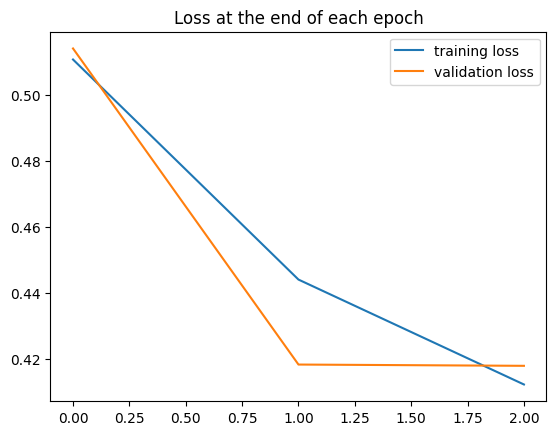

In [81]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

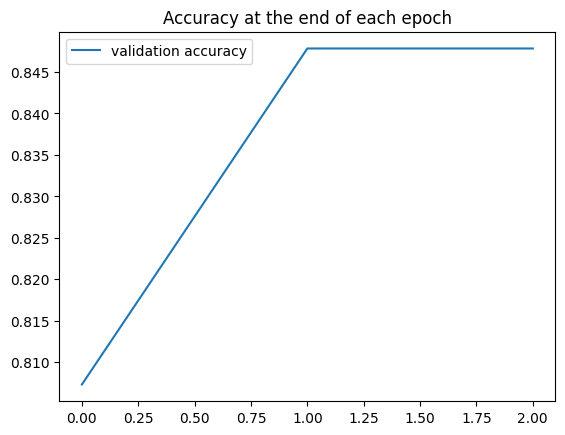

In [82]:
plt.plot(test_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [84]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]}%')

[tensor(0.8073), tensor(0.8478), tensor(0.8478)]
Test accuracy: 0.8478434681892395%


label:Ankle boot,pred:Ankle boot


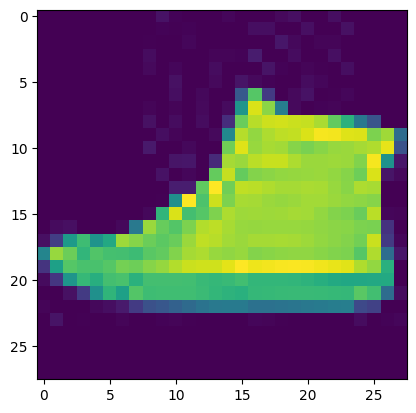

In [93]:
test_idx=12

#_ = plt.imshow(test_data[test_idx][0], cmap='gray')
_ = plt.imshow(np.transpose(test_data[test_idx][0].numpy(), (1, 2, 0)));
with torch.no_grad():
  model.eval()
  pred=model(test_data[test_idx][0])
  model.train()
print(f"label:{train_data.classes[test_data[test_idx][1]]},pred:{train_data.classes[torch.argmax(pred)]}")

## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [ ]:
AlexNetmodel = models.alexnet(pretrained=True).to(DEVICE)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 118MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<div class="alert alert-info">This model uses <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a> to convert the large matrix coming out of the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.</div>

## Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [ ]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

## Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [ ]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1)).to(DEVICE)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [ ]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


## Define loss function & optimizer
We only want to optimize the classifier parameters, as the feature parameters are frozen.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

## Train the model
Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [ ]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(tqdm(train_loader)):
        if b == max_trn_batch:
            break
        b+=1
        X_train=X_train.to(DEVICE)
        y_train=y_train.to(DEVICE)
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(tqdm(test_loader)):
            X_test, y_test=X_test.to(DEVICE),y_test.to(DEVICE)
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

 11%|█         | 200/1875 [01:33<11:47,  2.37it/s]

epoch:  0  batch:  200 [  2000/8000]  loss: 0.40178317  accuracy:  90.050%


 21%|██▏       | 400/1875 [03:05<13:27,  1.83it/s]

epoch:  0  batch:  400 [  4000/8000]  loss: 0.01158282  accuracy:  91.225%


 32%|███▏      | 600/1875 [04:37<09:22,  2.27it/s]

epoch:  0  batch:  600 [  6000/8000]  loss: 0.77661633  accuracy:  91.750%


 43%|████▎     | 800/1875 [06:20<08:30,  2.10it/s]


epoch:  0  batch:  800 [  8000/8000]  loss: 0.01528458  accuracy:  92.400%


 48%|████▊     | 300/626 [01:41<01:50,  2.96it/s]


Duration: 482 seconds


In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/3000:.3f}%')

[2730]
Test accuracy: 91.000%


## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.<br>
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set.

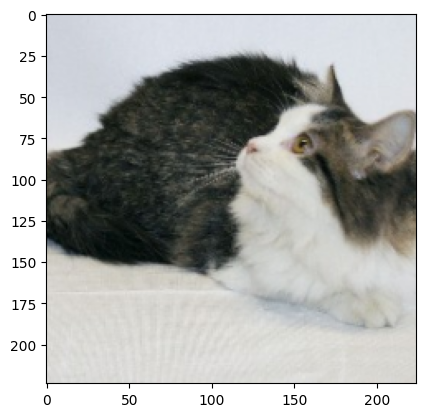

In [ ]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [ ]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [ ]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [ ]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
